In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import csv
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter

In [5]:
parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument("--vtkdir", type=str, help="name base of vtk files - they are usually in a vtk-subdirectory!", default="./output/")
parser.add_argument("--csvdir", type=str, default="./output/")
parser.add_argument("--resolution", type=int, default=128)
parser.add_argument("--nout", type=int, default=10)
parser.add_argument("--nvtk", type=int, default=200)
parser.add_argument("--tmax", type=int, default=10)
parser.add_argument("--Re", type=int, default=400)
args, unknown = parser.parse_known_args()
args = vars(args)
#args = vars(parser.parse_args())
Re=args["Re"]
basedir = args["vtkdir"]
csvdir = args["csvdir"]
res = args["resolution"]
nout = args["nout"]
nvtk = args["nvtk"]
tmax = args["tmax"]

In [6]:
lattice = lt.Lattice(lt.D3Q27, device = "cuda", dtype=torch.float64)
flow = lt.TaylorGreenVortex3D(resolution=res, reynolds_number=Re, mach_number=0.05, lattice=lattice)
collision = lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu)
streaming = lt.StandardStreaming(lattice)
simulation = lt.Simulation(flow=flow, lattice=lattice, collision=collision, streaming=streaming)

In [7]:
interval_vtk=int((flow.units.convert_time_to_lu(tmax))/100)
interval_out=int((flow.units.convert_time_to_lu(tmax))/200)
Energy = lt.IncompressibleKineticEnergy(lattice, flow)
Dissipation_TGV=lt.Dissipation_sij(lattice, flow)
Enstrophy=lt.Enstrophy(lattice, flow)

reporter = lt.ObservableReporter(Energy, interval=interval_out, out=None)
reporter2 = lt.ObservableReporter(Dissipation_TGV,interval = interval_out, out=None)
reporter3= lt.ObservableReporter(Enstrophy, interval=interval_out, out=None)
simulation.reporters.append(reporter)
simulation.reporters.append(reporter2)
simulation.reporters.append(reporter3)
steps = int(flow.units.convert_time_to_lu(tmax))
print(steps)
#simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=interval_vtk, filename_base=basedir+"out"))

steps     time     IncompressibleKineticEnergy
steps     time     Dissipation_sij
steps     time     Enstrophy
7057


In [5]:
simulation.initialize_f_neq()
steps = int(flow.units.convert_time_to_lu(tmax))
mlups = simulation.step(num_steps=steps)
print("Performance in MLUPS:", mlups)
print(steps)

Performance in MLUPS: 12.858700259431133


In [6]:
energy = np.array(simulation.reporters[0].out)
dissipation = np.array(simulation.reporters[1].out)
enstrophy=np.array(simulation.reporters[2].out)

dissipationEkin=np.array([energy[:,1],-1/(np.pi*2)**3*np.gradient(energy[:,2],energy[:,1])])
dissipationEns=np.array([enstrophy[:,1],flow.units.viscosity_pu/(np.pi*2)**3*enstrophy[:,2]])
dissipationSij=np.array([dissipation[:,1],dissipation[:,2]])

with open(csvdir + 'DissipationEkin.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationEkin)
with open(csvdir + 'DissipationEnstrophy.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationEns)
with open(csvdir + 'DissipationSij.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationSij)




[0.         0.04987948 0.09975897 0.14963845 0.19951793 0.24939741
 0.2992769  0.34915638 0.39903586 0.44891534 0.49879483 0.54867431
 0.59855379 0.64843327 0.69831276 0.74819224 0.79807172 0.8479512
 0.89783069 0.94771017 0.99758965 1.04746913 1.09734862 1.1472281
 1.19710758 1.24698706 1.29686655 1.34674603 1.39662551 1.44650499
 1.49638448 1.54626396 1.59614344 1.64602292 1.69590241 1.74578189
 1.79566137 1.84554085 1.89542034 1.94529982 1.9951793  2.04505878
 2.09493827 2.14481775 2.19469723 2.24457671 2.2944562  2.34433568
 2.39421516 2.44409464 2.49397413 2.54385361 2.59373309 2.64361257
 2.69349206 2.74337154 2.79325102 2.8431305  2.89300999 2.94288947
 2.99276895 3.04264843 3.09252792 3.1424074  3.19228688 3.24216636
 3.29204585 3.34192533 3.39180481 3.44168429 3.49156378 3.54144326
 3.59132274 3.64120222 3.69108171 3.74096119 3.79084067 3.84072015
 3.89059964 3.94047912 3.9903586  4.04023808 4.09011757 4.13999705
 4.18987653 4.23975601 4.2896355  4.33951498 4.38939446 4.439273

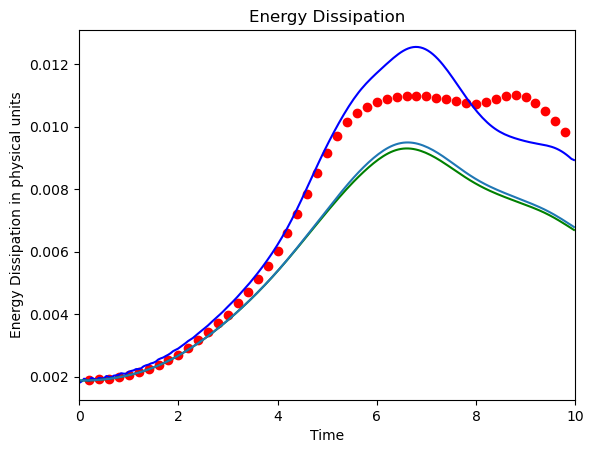

In [7]:
csv_file_path = '/home/ben/Schreibtisch/Enstropy Brachet/Brachet/Brachet_1983_tgv3d_enstrophy_Re400.csv'

# Daten aus der CSV-Datei lesen
csv_data = []
with open(csv_file_path, 'r') as file:
    csv_reader = csv.reader(file, delimiter=';')
    for row in csv_reader:
        csv_data.append(row)

csv_data = np.array(csv_data, dtype=float)
print(dissipationEkin[0,:])
plt.plot(dissipationEkin[0,:],dissipationEkin[1,:],color = 'blue')
plt.plot(dissipationEns[0,:],dissipationEns[1,:], color = 'green')
plt.xlim(0,10)
plt.plot(dissipationSij[0,:],dissipationSij[1,:])
plt.scatter(csv_data[:, 0], csv_data[:, 1], color='red', label='CSV Data')
plt.title('Energy Dissipation')
plt.xlabel('Time')
plt.ylabel('Energy Dissipation in physical units')
plt.show()